# Sentinel-1 SLC Burst Selection

This notebook demonstrates the **BURST open option** for efficiently selecting individual bursts from Sentinel-1 SLC products.

## Overview

Sentinel-1 SLC (Single Look Complex) products in IW (Interferometric Wide) mode contain many bursts spread across multiple subswaths and polarizations. A typical IW dual-pol product has **54 bursts** (9 bursts x 3 subswaths x 2 polarizations), producing over 1000 subdatasets.

The `BURST` open option provides a **friendly naming scheme** to directly select a specific burst without navigating the full subdataset list.

### Burst Naming Convention

```
{subswath}_{polarization}_{index}
```

Examples:
- `IW1_VV_001` - First VV burst in subswath IW1
- `IW2_VH_005` - Fifth VH burst in subswath IW2
- `IW3_VV_009` - Ninth VV burst in subswath IW3

### Dataset Used
- **S1C_IW_SLC__1SDV**: Sentinel-1C, IW mode, SLC, Dual VV/VH polarization

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Enable GDAL exceptions
gdal.UseExceptions()

print("Imports successful!")
print(f"GDAL version: {gdal.__version__}")

# Check driver registration
drv = gdal.GetDriverByName('EOPFZARR')
if drv:
    print(f"EOPFZARR driver: Registered")
else:
    print("WARNING: EOPFZARR driver not found!")

Imports successful!
GDAL version: 3.11.1
EOPFZARR driver: Registered


## 2. Dataset URL

We use a Sentinel-1C IW SLC product with dual VV/VH polarization.

In [2]:
SLC_URL = (
    "/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:"
    "notebook-data/tutorial_data/cpm_v262/"
    "S1C_IW_SLC__1SDV_20251016T165627_20251016T165654_004590_00913B_30C4.zarr"
)

print("SLC Product:")
print("  S1C_IW_SLC__1SDV - Sentinel-1C, IW mode, Dual VV/VH")
print(f"  URL: ...{SLC_URL[-60:]}")

SLC Product:
  S1C_IW_SLC__1SDV - Sentinel-1C, IW mode, Dual VV/VH
  URL: ...1SDV_20251016T165627_20251016T165654_004590_00913B_30C4.zarr


## 3. Explore the SLC Product Structure

Without the `BURST` option, opening an SLC product lists all subdatasets. A typical IW dual-pol product has many subdatasets, making it challenging to find a specific burst.

In [3]:
print("Opening SLC product (standard mode)...\n")
ds = gdal.Open(f"EOPFZARR:'{SLC_URL}'")

if ds:
    subdatasets = ds.GetMetadata("SUBDATASETS")
    subdataset_names = sorted([
        v for k, v in subdatasets.items() if "_NAME" in k
    ])
    
    # Filter for SLC measurement subdatasets
    slc_subdatasets = [s for s in subdataset_names if "measurements/slc" in s]
    
    print(f"Total subdatasets: {len(subdataset_names)}")
    print(f"SLC measurement subdatasets: {len(slc_subdatasets)}")
    
    print(f"\nFirst 10 SLC subdatasets:")
    print("-" * 80)
    for sd in slc_subdatasets[:10]:
        # Extract just the group name for readability
        parts = sd.split('"')
        if len(parts) >= 2:
            path = parts[-1].lstrip('/')
        else:
            path = sd
        print(f"  {path}")
    if len(slc_subdatasets) > 10:
        print(f"  ... and {len(slc_subdatasets) - 10} more")
    
    ds = None
else:
    print("Failed to open dataset")

Opening SLC product (standard mode)...

Total subdatasets: 1296
SLC measurement subdatasets: 54

First 10 SLC subdatasets:
--------------------------------------------------------------------------------
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92598/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92599/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92600/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92601/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92602/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92603/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92604/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92605/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW1_92606/measurements/slc
  :/S01SIWSLC_20251016T165627_0027_C026_30C4_00913B_VH_IW2

## 4. Select a Burst with the BURST Open Option

Instead of navigating the full subdataset list, use the `BURST` open option to directly select a burst by its friendly name.

In [4]:
print("Opening burst IW1_VV_001...\n")

ds_burst = gdal.OpenEx(
    f"EOPFZARR:'{SLC_URL}'",
    gdal.OF_RASTER | gdal.OF_READONLY,
    open_options=["BURST=IW1_VV_001"]
)

if ds_burst:
    print("=" * 70)
    print("Burst Dataset Information:")
    print("=" * 70)
    print(f"Dimensions:  {ds_burst.RasterXSize} x {ds_burst.RasterYSize} pixels")
    print(f"Band Count:  {ds_burst.RasterCount}")
    
    band = ds_burst.GetRasterBand(1)
    print(f"Data Type:   {gdal.GetDataTypeName(band.DataType)}")
    print(f"Block Size:  {band.GetBlockSize()}")
    
    print("\nBurst Metadata:")
    print("-" * 70)
    print(f"  EOPF_PRODUCT_TYPE:      {ds_burst.GetMetadataItem('EOPF_PRODUCT_TYPE')}")
    print(f"  EOPF_BURST_NAME:        {ds_burst.GetMetadataItem('EOPF_BURST_NAME')}")
    print(f"  EOPF_BURST_SUBSWATH:    {ds_burst.GetMetadataItem('EOPF_BURST_SUBSWATH')}")
    print(f"  EOPF_BURST_POLARIZATION:{ds_burst.GetMetadataItem('EOPF_BURST_POLARIZATION')}")
    print(f"  EOPF_BURST_INDEX:       {ds_burst.GetMetadataItem('EOPF_BURST_INDEX')}")
    print("=" * 70)
else:
    print("Failed to open burst")

Opening burst IW1_VV_001...

Burst Dataset Information:
Dimensions:  23261 x 1501 pixels
Band Count:  1
Data Type:   CFloat32
Block Size:  [4096, 1501]

Burst Metadata:
----------------------------------------------------------------------
  EOPF_PRODUCT_TYPE:      SLC
  EOPF_BURST_NAME:        IW1_VV_001
  EOPF_BURST_SUBSWATH:    IW1
  EOPF_BURST_POLARIZATION:VV
  EOPF_BURST_INDEX:       1


## 5. Compare Bursts Across Subswaths

Sentinel-1 IW mode uses three subswaths (IW1, IW2, IW3). Let's compare the first VV burst from each.

In [5]:
subswaths = ["IW1", "IW2", "IW3"]
burst_datasets = {}

print("Opening first VV burst from each subswath...\n")
print(f"{'Subswath':<12} {'Burst Name':<16} {'Width':<8} {'Height':<8} {'Data Type':<12}")
print("-" * 60)

for sw in subswaths:
    burst_name = f"{sw}_VV_001"
    ds = gdal.OpenEx(
        f"EOPFZARR:'{SLC_URL}'",
        gdal.OF_RASTER | gdal.OF_READONLY,
        open_options=[f"BURST={burst_name}"]
    )
    if ds:
        burst_datasets[sw] = ds
        dtype = gdal.GetDataTypeName(ds.GetRasterBand(1).DataType)
        print(f"{sw:<12} {burst_name:<16} {ds.RasterXSize:<8} {ds.RasterYSize:<8} {dtype:<12}")
    else:
        print(f"{sw:<12} {burst_name:<16} FAILED TO OPEN")

print(f"\nSuccessfully opened {len(burst_datasets)} subswath bursts")

Opening first VV burst from each subswath...

Subswath     Burst Name       Width    Height   Data Type   
------------------------------------------------------------
IW1          IW1_VV_001       23261    1501     CFloat32    
IW2          IW2_VV_001       27012    1511     CFloat32    
IW3          IW3_VV_001       25954    1516     CFloat32    

Successfully opened 3 subswath bursts


## 6. Visualize SLC Burst Amplitude

SLC data is complex-valued (CFloat32). We compute the amplitude (magnitude) for visualization.

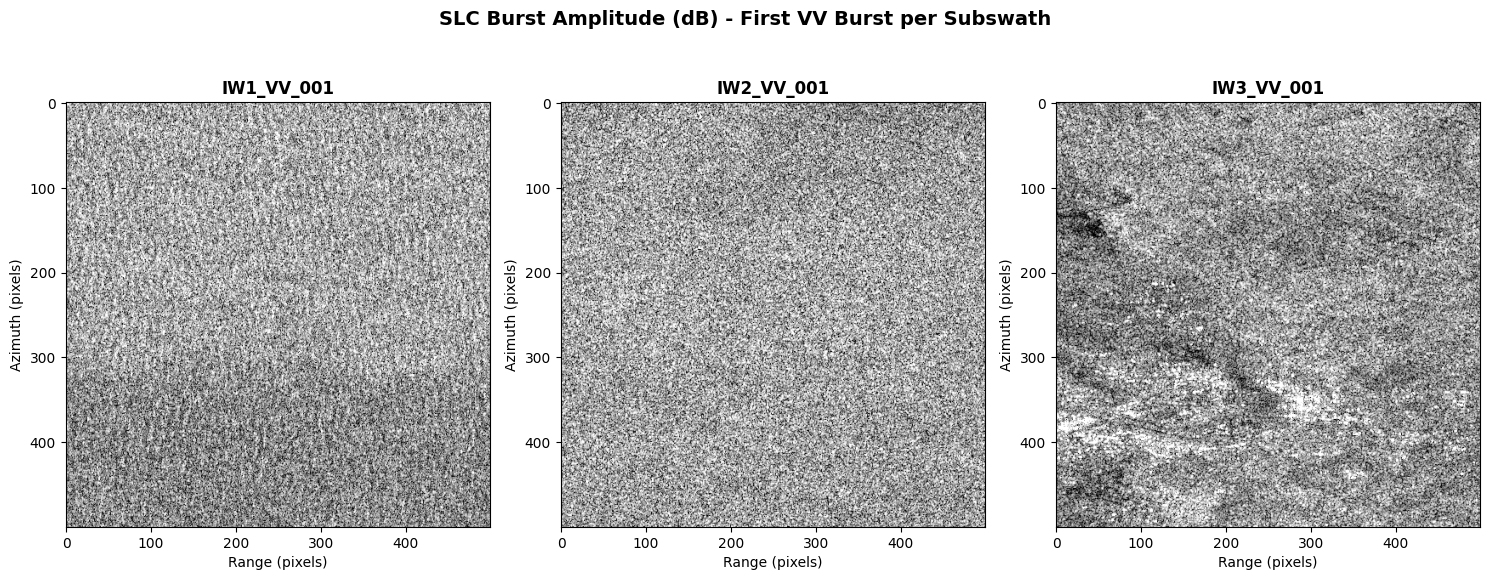

Visualization complete!


In [6]:
if burst_datasets:
    fig, axes = plt.subplots(1, len(burst_datasets), figsize=(5 * len(burst_datasets), 6))
    if len(burst_datasets) == 1:
        axes = [axes]
    
    for idx, (sw, ds) in enumerate(burst_datasets.items()):
        # Read a subset for visualization
        x_size = min(500, ds.RasterXSize)
        y_size = min(500, ds.RasterYSize)
        x_off = (ds.RasterXSize - x_size) // 2
        y_off = (ds.RasterYSize - y_size) // 2
        
        data = ds.GetRasterBand(1).ReadAsArray(x_off, y_off, x_size, y_size)
        
        # Compute amplitude from complex data
        amplitude = np.abs(data)
        
        # Convert to dB for better visualization
        amplitude_db = 10 * np.log10(amplitude + 1)
        
        vmin, vmax = np.nanpercentile(amplitude_db, [2, 98])
        axes[idx].imshow(amplitude_db, cmap='gray', vmin=vmin, vmax=vmax)
        axes[idx].set_title(f'{sw}_VV_001', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Range (pixels)')
        axes[idx].set_ylabel('Azimuth (pixels)')
    
    plt.suptitle('SLC Burst Amplitude (dB) - First VV Burst per Subswath', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("Visualization complete!")
else:
    print("No burst datasets available")

## 7. Compare VV and VH Polarizations

Let's compare VV and VH bursts from the same subswath to see the polarization difference.

Opening IW1_VV_001 and IW1_VH_001...



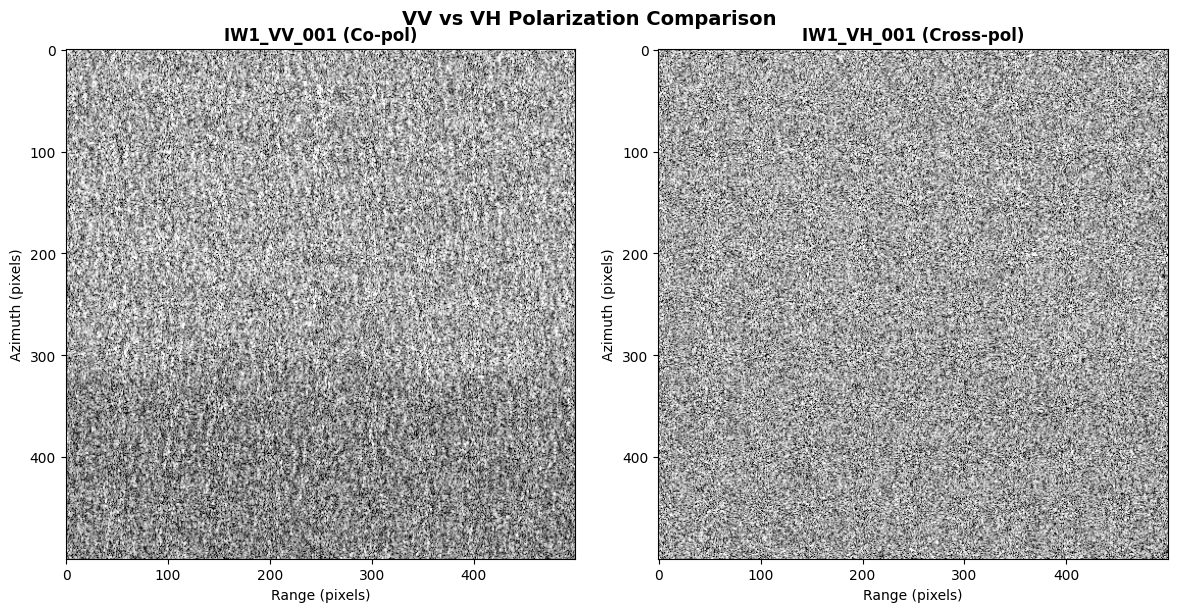

VV amplitude range: 0.00 - 368.40
VH amplitude range: 0.00 - 53.01


In [7]:
print("Opening IW1_VV_001 and IW1_VH_001...\n")

ds_vv = gdal.OpenEx(
    f"EOPFZARR:'{SLC_URL}'",
    gdal.OF_RASTER | gdal.OF_READONLY,
    open_options=["BURST=IW1_VV_001"]
)

ds_vh = gdal.OpenEx(
    f"EOPFZARR:'{SLC_URL}'",
    gdal.OF_RASTER | gdal.OF_READONLY,
    open_options=["BURST=IW1_VH_001"]
)

if ds_vv and ds_vh:
    # Read a subset
    x_size = min(500, ds_vv.RasterXSize)
    y_size = min(500, ds_vv.RasterYSize)
    x_off = (ds_vv.RasterXSize - x_size) // 2
    y_off = (ds_vv.RasterYSize - y_size) // 2
    
    vv_data = ds_vv.GetRasterBand(1).ReadAsArray(x_off, y_off, x_size, y_size)
    vh_data = ds_vh.GetRasterBand(1).ReadAsArray(x_off, y_off, x_size, y_size)
    
    vv_amp = 10 * np.log10(np.abs(vv_data) + 1)
    vh_amp = 10 * np.log10(np.abs(vh_data) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    vmin, vmax = np.nanpercentile(vv_amp, [2, 98])
    axes[0].imshow(vv_amp, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('IW1_VV_001 (Co-pol)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Range (pixels)')
    axes[0].set_ylabel('Azimuth (pixels)')
    
    vmin, vmax = np.nanpercentile(vh_amp, [2, 98])
    axes[1].imshow(vh_amp, cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('IW1_VH_001 (Cross-pol)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Range (pixels)')
    axes[1].set_ylabel('Azimuth (pixels)')
    
    plt.suptitle('VV vs VH Polarization Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"VV amplitude range: {np.abs(vv_data).min():.2f} - {np.abs(vv_data).max():.2f}")
    print(f"VH amplitude range: {np.abs(vh_data).min():.2f} - {np.abs(vh_data).max():.2f}")
    
    ds_vv = None
    ds_vh = None
else:
    print("Failed to open one or both polarization bursts")

## 8. Summary

### BURST Open Option Features

| Feature | Description |
|---------|-------------|
| **Friendly Names** | `{subswath}_{polarization}_{index}` (e.g., `IW1_VV_001`) |
| **Case Insensitive** | `iw1_vv_001` works the same as `IW1_VV_001` |
| **Auto-Detection** | SLC products detected by `_SLC` pattern in path |
| **Metadata** | Burst name, subswath, polarization, and index in dataset metadata |
| **Data Type** | CFloat32 (complex single-precision) |
| **Error Handling** | Invalid burst names list all valid options |

### Usage Examples

```python
# Select a specific burst
ds = gdal.OpenEx("EOPFZARR:'/vsicurl/...SLC...zarr'",
                 open_options=["BURST=IW1_VV_001"])

# Read complex SLC data
data = ds.GetRasterBand(1).ReadAsArray()
amplitude = np.abs(data)
phase = np.angle(data)

# Check burst metadata
print(ds.GetMetadataItem('EOPF_BURST_NAME'))         # IW1_VV_001
print(ds.GetMetadataItem('EOPF_BURST_SUBSWATH'))     # IW1
print(ds.GetMetadataItem('EOPF_BURST_POLARIZATION')) # VV
```

### Command Line Usage

```bash
gdalinfo "EOPFZARR:'/vsicurl/...SLC...zarr'" -oo BURST=IW1_VV_001
```

## 9. Cleanup

In [8]:
# Close all datasets
for sw, ds in burst_datasets.items():
    ds = None
burst_datasets.clear()

if 'ds_burst' in dir() and ds_burst:
    ds_burst = None

print("All datasets closed")

All datasets closed
